# The ATM Camera
We are tasked with making a smart ATM camera which can distinguish between dollar notes and checks.We want to make sure that dollars are not classified as checks, and that checks are not classified as dollars.

We are given a set of 87 images of checks and dollars, each of which have been scaled to 322 X 137 pixels, and where each pixel has 3 color channels.

**download imag.pix.npy from https://drive.google.com/open?id=0B-8JzeE81nw8MFBCRDZFdDhacGc and move this file to the data folder**

In [1]:
# Importing all the required libraries
# It's just an Ipython thing which opens plots in the same window instead of a separate window
%matplotlib inline 
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import scipy as sp
import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import pandas as pd

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn as sns
sns.set_style("whitegrid")
sns.set_context("poster")

from PIL import Image

In [17]:
c0=sns.color_palette()[0]
c1=sns.color_palette()[1]
c2=sns.color_palette()[2]

In [21]:
from matplotlib.colors import ListedColormap
cmap_light = ListedColormap(['#FFAAAA', '#AAFFAA', '#AAAAFF'])
cmap_bold = ListedColormap(['#FF0000', '#00FF00', '#0000FF'])
cm = plt.cm.RdBu
cm_bright = ListedColormap(['#FF0000', '#0000FF'])

def points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=True, colorscale=cmap_light, cdiscrete=cmap_bold, alpha=0.1, psize=10, zfunc=False, predicted=False):
    h = .02
    X=np.concatenate((Xtr, Xte))
    x_min, x_max = X[:, 0].min() - .5, X[:, 0].max() + .5
    y_min, y_max = X[:, 1].min() - .5, X[:, 1].max() + .5
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, 100),
                         np.linspace(y_min, y_max, 100))

    #plt.figure(figsize=(10,6))
    if zfunc:
        p0 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 0]
        p1 = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
        Z=zfunc(p0, p1)
    else:
        Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    ZZ = Z.reshape(xx.shape)
    if mesh:
        plt.pcolormesh(xx, yy, ZZ, cmap=cmap_light, alpha=alpha, axes=ax)
    if predicted:
        showtr = clf.predict(Xtr)
        showte = clf.predict(Xte)
    else:
        showtr = ytr
        showte = yte
    ax.scatter(Xtr[:, 0], Xtr[:, 1], c=showtr-1, cmap=cmap_bold, s=psize, alpha=alpha,edgecolor="k")
    # and testing points
    ax.scatter(Xte[:, 0], Xte[:, 1], c=showte-1, cmap=cmap_bold, alpha=alpha, marker="s", s=psize+10)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    return ax,xx,yy

In [22]:
def points_plot_prob(ax, Xtr, Xte, ytr, yte, clf, colorscale=cmap_light, cdiscrete=cmap_bold, ccolor=cm, psize=10, alpha=0.1):
    ax,xx,yy = points_plot(ax, Xtr, Xte, ytr, yte, clf, mesh=False, colorscale=colorscale, cdiscrete=cdiscrete, psize=psize, alpha=alpha, predicted=True) 
    Z = clf.predict_proba(np.c_[xx.ravel(), yy.ravel()])[:, 1]
    Z = Z.reshape(xx.shape)
    plt.contourf(xx, yy, Z, cmap=ccolor, alpha=.2, axes=ax)
    cs2 = plt.contour(xx, yy, Z, cmap=ccolor, alpha=.6, axes=ax)
    plt.clabel(cs2, fmt = '%2.1f', colors = 'k', fontsize=14, axes=ax)
    return ax 

In [3]:
data=np.load("data/imag.pix.npy")
y=np.load("data/imag.lbl.npy")
STANDARD_SIZE = (322, 137)#standardized pixels in image.
data.shape, y.shape

((87, 132342), (87,))

We display some of the images that we have:

In [4]:
def get_image(mat):
    size = STANDARD_SIZE[0]*STANDARD_SIZE[1]*3
    r,g,b = mat[0:size:3], mat[1:size:3],mat[2:size:3]
    rgbArray = np.zeros((STANDARD_SIZE[1],STANDARD_SIZE[0], 3), 'uint8')#3 channels
    rgbArray[..., 0] = r.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 1] = b.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    rgbArray[..., 2] = g.reshape((STANDARD_SIZE[1], STANDARD_SIZE[0]))
    return rgbArray

def display_image(mat):
    with sns.axes_style("white"):
        plt.imshow(get_image(mat))
        plt.xticks([])
        plt.yticks([])

Image of a CHECK

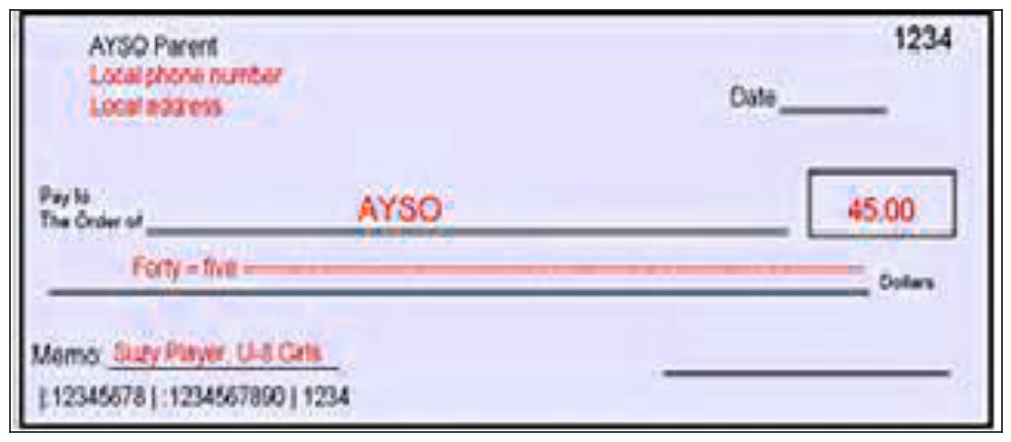

In [5]:
display_image(data[5])

Image of a U.S. Dollar

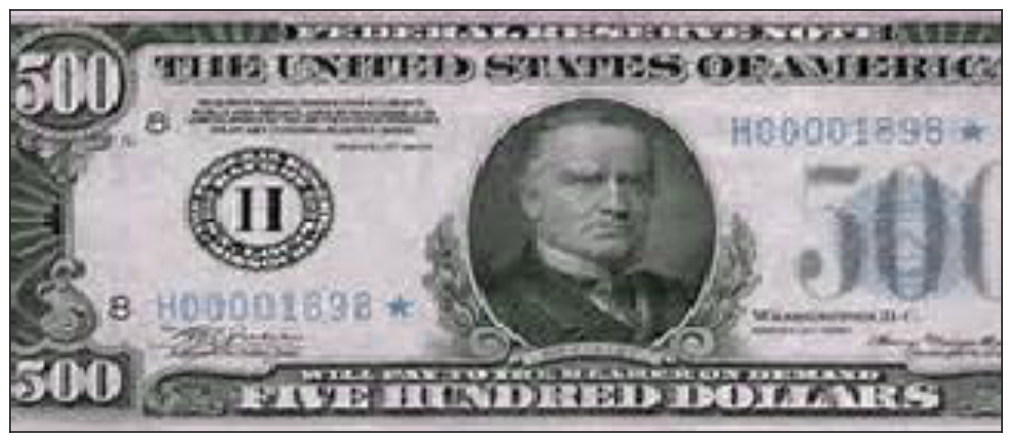

In [6]:
display_image(data[50])

### The curse of dimensionality: Feature engineering

The first thing that we notice is that we have many many features: to be precise, $322 x 137 x 3 = 136452$ of them. This is a lot of features! Having too many features can lead to overfitting.

Another way to look at this problem is the following: we have 85 data points, but 136452 features; that is, way more features than data points. Thus there is a high chance that a few attributes will correlate with $y$ purely coincidentally!
[^Having lots of images, or "big-data" helps in combatting overfitting!]

We will engage in some *a-priori* feature selection that will reduce the dimensionality of the problem. The idea we'll use here is something called **Principal Components Analysis**, or PCA.

PCA is an unsupervized learning technique. The basic idea behind PCA is to rotate the co-ordinate axes of the feature space. We first find the direction in which the data varies the most. We set up one co-ordinate axes along this direction, which is called the first principal component. We then look for a perpendicular direction in which the data varies the second most. This is the second principal component. The diagram illustrates this process. There are as many principal components as the feature dimension: all we have done is a rotation.

![pcanim](images/pcanim.gif)

(diagram taken from http://stats.stackexchange.com/questions/2691/making-sense-of-principal-component-analysis-eigenvectors-eigenvalues which also has nice discussions)

How does this then achieve feature selection? We decide on a threshold of variation; once the variation in a particular direction falls below a certain number, we get rid of all the co-ordinate axes after that principal component. For example, if the variation falls below 10% after the third axes, and we decide that 10% is an acceptable cutoff, we remove all domensions from the fourth dimension onwards. In other words, we took our higher dimensional problem and projected it onto a 3 dimensional **subspace**.

These two ideas illustrate one of the most important reasons that learning is even feasible: we believe that **most datasets, in either their unsupervized form $\{\v{x\}}$, or their supervized form $\{y, \v{x}\}$, live on a lower dimensional subspace**. If we can find this subspace, we can then hope to find a method which respectively separates or fits the data.

Here we'll continue to focus on PCA. We'll reduce our dimensionality from 136452 to 60. We choose 60 as a large apriori number: we dont know if the variation in the data will have gone below a reasonable threshold by then. Notice that we use `fit_transform` in the `sklearn` API which takes the original 87 rows x 136452 columns dimensional data `data` and transforms it to a 87 x 90 data matrix `X`

In [7]:
from sklearn.decomposition import PCA
pca = PCA(n_components=60)
X = pca.fit_transform(data)

In [33]:
print pca.explained_variance_ratio_.sum()

0.942517727403


The explained variance ratio `pca.explained_variance_ratio_` tells us how much of the variation in the features is explained by these 60 features. When we sum it up over the features, we see that 94% is explained: good enough to go down to a 60 dimensional space from a 136452 dimensional one!

We can see the individual varainces as we increase the dimensionality:

In [9]:
pca.explained_variance_ratio_*100

array([ 35.92596698,   6.29318801,   4.10778347,   3.11950952,
         2.81695972,   2.28831619,   2.10127948,   1.87404972,
         1.73264635,   1.53023757,   1.42159632,   1.31839387,
         1.24701501,   1.16381767,   1.09958246,   1.06073096,
         1.00742709,   0.98023627,   0.96055703,   0.91535041,
         0.90185445,   0.85212337,   0.83673085,   0.79691683,
         0.75488955,   0.72504809,   0.70810497,   0.67965443,
         0.6608896 ,   0.64768067,   0.62733756,   0.59472293,
         0.58291162,   0.57446687,   0.57261714,   0.55241183,
         0.5383977 ,   0.53333525,   0.51647796,   0.49326173,
         0.4853282 ,   0.47736271,   0.47200811,   0.45590127,
         0.4431691 ,   0.43974382,   0.43387969,   0.42625863,
         0.42155544,   0.40831131,   0.40490267,   0.39283743,
         0.38829814,   0.38018663,   0.37326643,   0.36088464,
         0.35867847,   0.34800511,   0.3387236 ,   0.3279939 ])

The first dimension accounts for 35% of the variation, the second 6%, and it goes steadily down from there.

Let us create a dataframe with these 60 features labelled pc1,pc2...,pc60 and the labels of the sample:

In [12]:
df = pd.DataFrame({"y":y, "label":np.where(y==1, "check", "dollar")})
for i in range(pca.explained_variance_ratio_.shape[0]):
    df["pc%i" % (i+1)] = X[:,i]
df.head()

,label,y,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc11,pc12,pc13,pc14,pc15,pc16,pc17,pc18,pc19,pc20,pc21,pc22,pc23,pc24,pc25,pc26,pc27,pc28,pc29,pc30,pc31,pc32,pc33,pc34,pc35,pc36,pc37,pc38,pc39,pc40,pc41,pc42,pc43,pc44,pc45,pc46,pc47,pc48,pc49,pc50,pc51,pc52,pc53,pc54,pc55,pc56,pc57,pc58,pc59,pc60
0,check,1,-22536.362571,-2428.343881,-2133.778654,-328.315167,-1065.244935,79.751089,-425.044522,622.473470,-2490.235234,-858.625406,-1072.739717,277.338468,-1117.632799,713.232053,-788.152163,415.330332,-196.426333,472.402955,-428.260040,-609.615315,-589.374363,-267.977782,-985.580554,955.838548,1038.101443,571.434103,-38.025535,-111.444917,-515.419989,548.684126,-651.430312,76.420204,-728.238531,1263.213011,-570.152301,-132.408164,490.011465,294.191539,-248.829449,48.852969,-476.402972,790.310302,527.419954,-425.422321,479.078909,-249.856538,-14.054258,295.129589,639.375064,-413.840231,-645.843829,104.977674,286.880096,227.000565,204.690312,362.838823,-367.031617,-105.476193,-252.647043,-145.515006
1,check,1,-22226.658684,-709.255622,-288.828952,-1300.623807,-792.079844,217.399929,1076.812657,-2115.197190,-875.369816,-1124.906377,-343.366448,-43.206764,547.400851,358.287158,-1762.085941,-371.745415,812.608885,293.981164,-939.109267,156.749465,-1122.593221,508.925711,-816.864442,720.657425,288.744718,-116.338984,830.702406,1152.818226,-355.451356,122.820742,-867.620263,576.392497,323.060849,171.307213,-691.497496,-660.592823,-114.819655,-186.334422,-133.453951,-381.891612,82.586705,40.544842,731.949079,22.936331,321.830227,-6.799914,28.684726,418.281904,-1158.224617,228.609238,-442.277211,-152.162484,138.813885,-628.020400,502.167440,351.173132,-232.657107,203.933576,-157.606857,-447.203684
2,check,1,-17364.260784,-4252.027339,793.802272,-1362.051898,-374.229879,3142.094522,2514.186949,1443.906396,-121.040048,-419.881696,-2083.146966,1717.481411,-723.126194,-1239.879985,-310.764048,-1059.301700,1386.250730,-799.640055,-2600.094450,-880.422727,3382.583043,-394.433198,-3410.545813,1337.285715,-4754.132060,1036.925349,2211.351463,-689.978524,1380.291957,-2163.528410,-640.334232,1696.781395,1779.175882,-3148.445702,-899.679519,2311.309173,-3028.425497,3045.493507,843.163883,269.238279,1506.726842,-3167.784697,3762.513396,1573.499583,812.144537,583.253509,-907.626091,-1021.615449,184.965036,-2451.420219,-2778.376143,-1922.169910,585.094215,2346.379958,230.420305,2689.840976,-139.418108,-535.682281,-1302.156457,1386.339072
3,check,1,-22847.256199,-900.592736,577.202127,-180.356175,-733.177677,-107.825722,1441.702751,-1069.341036,844.183935,-1389.694656,1470.681163,-724.495531,-578.435922,-260.814973,932.540647,167.770069,-301.431753,870.203161,-183.653629,1229.524413,557.588908,-178.598619,-311.478128,-373.256561,-918.619516,189.651744,1269.960852,73.422847,-286.175630,-444.791500,-140.480841,-66.494644,96.347819,852.703020,-167.296771,642.997115,375.239801,307.053860,172.091857,-364.574305,1443.536640,-803.972919,-960.156695,594.051478,470.853357,-507.618837,-805.532873,-309.484195,1101.745182,-1472.021544,-114.038992,49.401849,61.067276,426.506747,200.244924,-700.370855,-542.567106,-747.487327,930.468082,1245.172927
4,check,1,-15868.672595,3259.490950,506.805248,-919.648698,2166.530434,-981.609217,-1669.780548,-391.114114,1735.622091,163.576534,-1627.094770,-556.535502,-862.434238,1721.205351,944.995298,-1134.071084,2141.223921,765.901060,-1095.785318,599.646903,-29.198194,80.216536,-501.665227,1099.406955,338.501535,-1224.331844,-714.722336,-726.264946,-149.598651,-918.305686,1043.412945,-3608.676418,2089.919279,-3369.743018,-1000.493284,-2117.886268,1910.882115,2126.027672,2554.394477,-509.937422,40.276456,1330.193810,1220.960654,-1290.077375,-270.174689,-896.813375,407.272956,834.520226,-3192.721918,1480.233620,-761.412351,-2585.523271,-337.350658,-1573.808273,2537.182171,-2789.449590,1469.724265,-2280.157676,-1974.021486,-625.579753


Lets see what these principal components look like:

In [13]:
def normit(a):
    a=(a - a.min())/(a.max() -a.min())
    a=a*256
    return np.round(a)
def getNC(pc, j):
    size=322*137*3
    r=pc.components_[j][0:size:3]
    g=pc.components_[j][1:size:3]
    b=pc.components_[j][2:size:3]
    r=normit(r)
    g=normit(g)
    b=normit(b)
    return r,g,b
def display_component(pc, j):
    r,g,b = getNC(pc,j)
    rgbArray = np.zeros((137,322,3), 'uint8')
    rgbArray[..., 0] = r.reshape(137,322)
    rgbArray[..., 1] = g.reshape(137,322)
    rgbArray[..., 2] = b.reshape(137,322)
    plt.imshow(rgbArray)
    plt.xticks([])
    plt.yticks([])

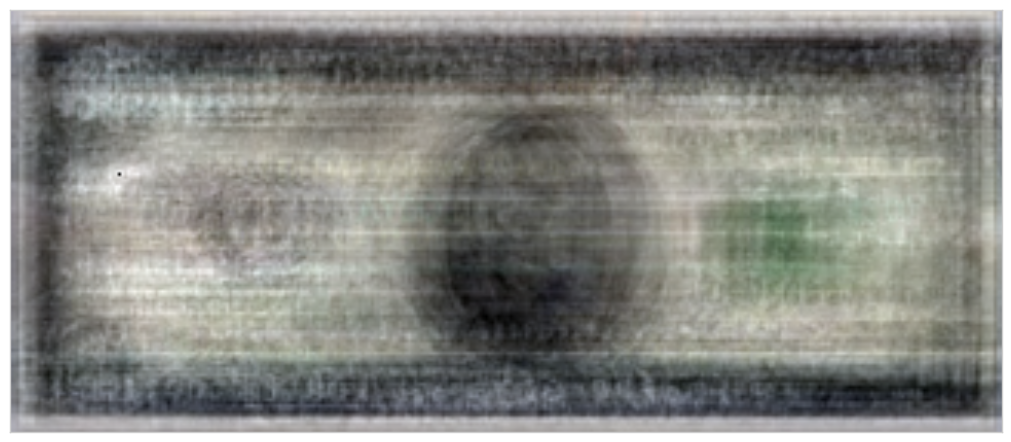

In [14]:
display_component(pca,0)

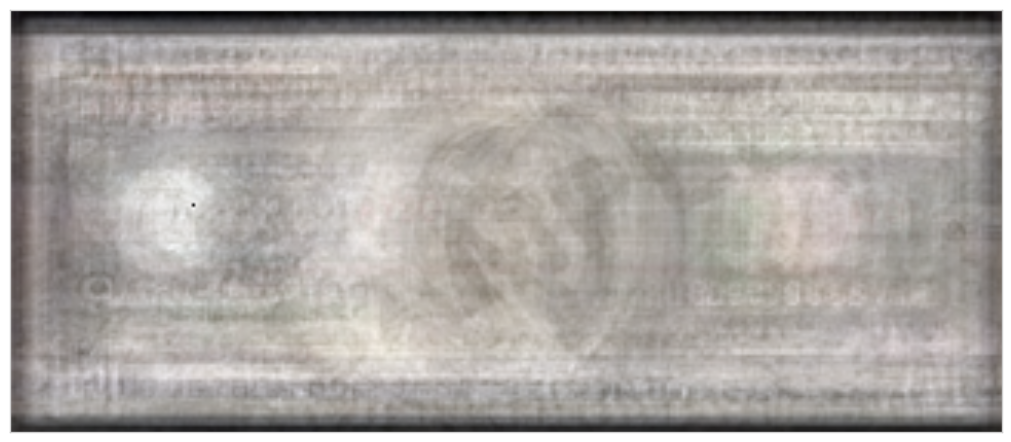

In [15]:
display_component(pca,1)

We take the first two principal components and immediately notice in the diagram below that they are enough to separate out the checks and the dollars. Indeed the first component itself seems to be mostly enough. We can look at the image of the first component and speculate that the medallion in the middle of the dollars probably contributes to this.

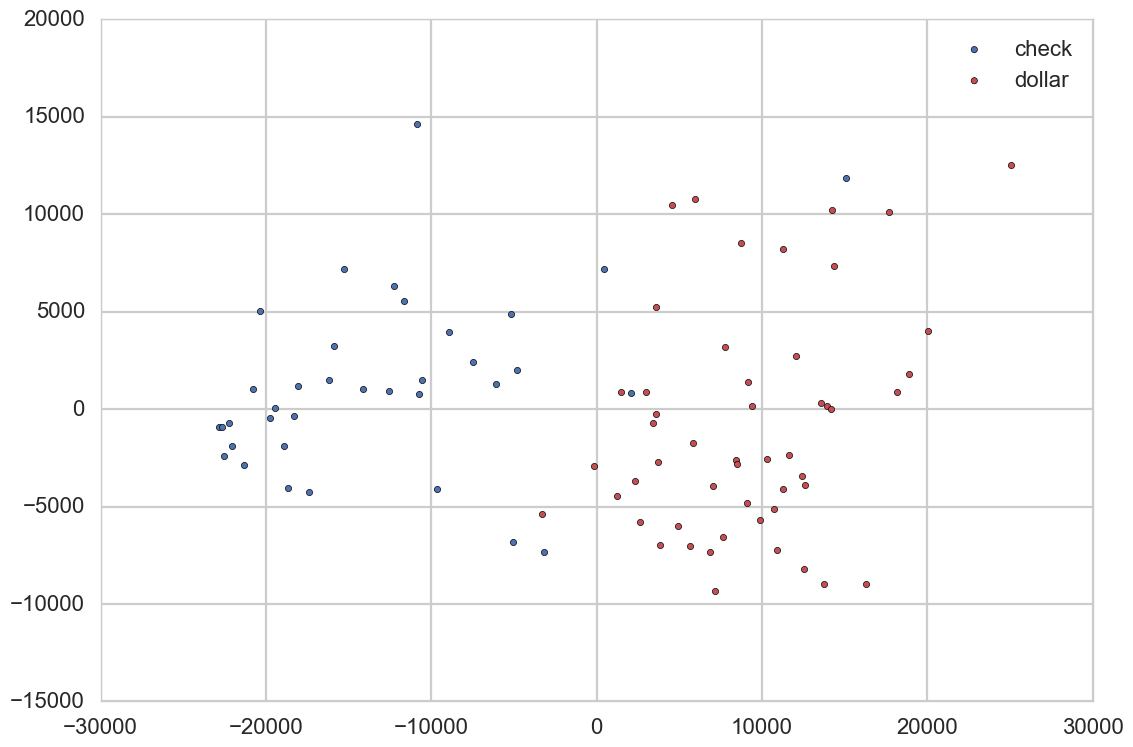

In [18]:
colors = [c0, c2]
for label, color in zip(df['label'].unique(), colors):
    mask = df['label']==label
    plt.scatter(df[mask]['pc1'], df[mask]['pc2'], c=color, label=label)
plt.legend()

## Classifying in a reduced feature space with kNN

![m:knn1](images/knn1.png)

Implicit in the notion of classification, is the idea that samples close to each other in feature-space share a label. kNN is a very simple algorithm to diretly use this idea to do classification. The basic notion is this: if a lot of samples in some area of the feature space belong to one class as compared to the other, we'll label that part of the feature space as "belonging" to that class. This process will then classify the feature space into class-based regions. Then, given the point in feature space, we find which region its in and thus its class. 

The way kNN does this is to ask for the k nearest neighbors in the training set of the new sample. To answer this question, one must define a distance in the feature space (Note that this distance is different from the error or risk measures we have seen earlier). This distance is typically defined as the **Euclidean distance**, the sum of the square of the difference of each feature value between any two samples.

$$D(s_1,s_2) = \sum_f (x_{f1} - x_{f2})^2.$$

Once we have a distance measure, we can sort the distances from the current sample. Then we choose the $k$ closest ones in the training set, where $k$ is an odd number (to break ties) like 1,3,5,...19,. We now see how many of these $k$ "nearest neighbors" belong to one class or the other, and choose the majority class amongst those neighbors as our sample's class.

The training process thus simply consists of memorizing the data, perhaps using a database to aid in the fast lookup of the $k$ nearest training set neighbors of any point in feature space. Notice that this process divides feature space into regions of one class or the other, since one can simply ask what the $k$ nearest neighbors in the training set are of any given point in feature space. Also notice that since classification happens via a majority "voting" scheme, we also know the probability that a point in feature space belongs to a class, as estimated by the fraction of $k$ nearest neighbors to that point in the desired class.

Thanks to `sklearn`'s simple api, the classifier is really simple to write:

In [19]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.cross_validation import train_test_split
ys=df['y'].astype(int).values
subdf=df[['pc1','pc2']]
subdfstd=(subdf - subdf.mean())/subdf.std()
Xs=subdfstd.values
def classify(X,y, nbrs, plotit=True, train_size=0.6):
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf= KNeighborsClassifier(nbrs)
    clf=clf.fit(Xtrain, ytrain)
    #in sklearn accuracy can be found by using "score". It predicts and then gets the accuracy
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    Xall=np.concatenate((Xtrain, Xtest))
    if plotit:
        print "Accuracy on training data: %0.2f" % (training_accuracy)
        print "Accuracy on test data:     %0.2f" % (test_accuracy)
        plt.figure()
        ax=plt.gca()
        points_plot(ax, Xtrain, Xtest, ytrain, ytest, clf, alpha=0.3, psize=20)
    return nbrs, training_accuracy, test_accuracy

/home/manish/anaconda2/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


Lets see what happens when we choose $k=1$. On the training set, the 1NN classifier memorizes the training data. It will predict perfectly on the training set, and wont do too badly on the test set, especially deep in the regions of feature space where one or the other class dominates. This is because evem one neighbor might be enough in those regions. However, the same classifier will do badly near the clasification boundaries on the test set, because you will need more than one neighbor to decide with any certainty of the class.

The result of this is, as you might expect, the regions of feature space classfied one way or the other (blue is check, red is dollar) are quite jagged and mottled. Since we are choosing just one neighbor, we fit to the noise in the region rather than the trend. We are overfitting.

Accuracy on training data: 1.00
Accuracy on test data:     0.91


(1, 1.0, 0.91428571428571426)

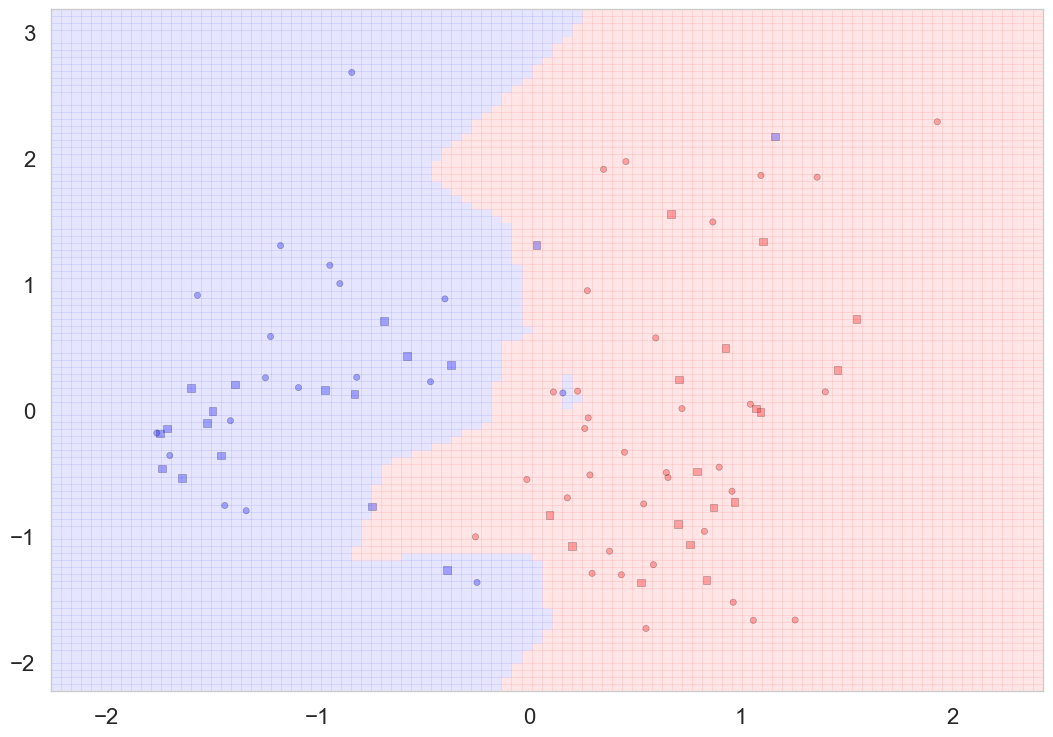

In [23]:
classify(Xs,ys,1)

If we choose too large a number for $k$, such as 50, we are wandering too far from our original sample,and thus we average over a large amount of the feature space. This leads to a very biased classification, depending on where our sample is, but extending far out from there. Our classification may even cover the entire feature space, then giving us the majority class.

In terms of probabilities, such an underfit case gives us the **base rate** classifier. Imagine $k=N$. Then the probability is just the fraction of training set examples in a given class. Say this number for the blue class is 0.4 (that is, whe have uneven class memberships in the training set). Now, on any random test set, if we use the classifier which says "classify all as red", we will be correct, on average, 60% of the time if the test set and training sets are representative of the population of samples. Any classifier we create must do a better job than this!

### Error against complexity (k), and cross-validation

In [36]:
fits={}
for k in np.arange(1,45,1):
    fits[k]=[]
    for i in range(200):
        fits[k].append(classify(Xs, ys,k, False))
nbrs=np.arange(1,45,1)
fmeanstr = np.array([1.-np.mean([t[1] for t in fits[e]]) for e in nbrs])
fmeanste = np.array([1.-np.mean([t[2] for t in fits[e]]) for e in nbrs])
fstdsstr = np.array([np.std([t[1] for t in fits[e]]) for e in nbrs])
fstdsste = np.array([np.std([t[2] for t in fits[e]]) for e in nbrs])

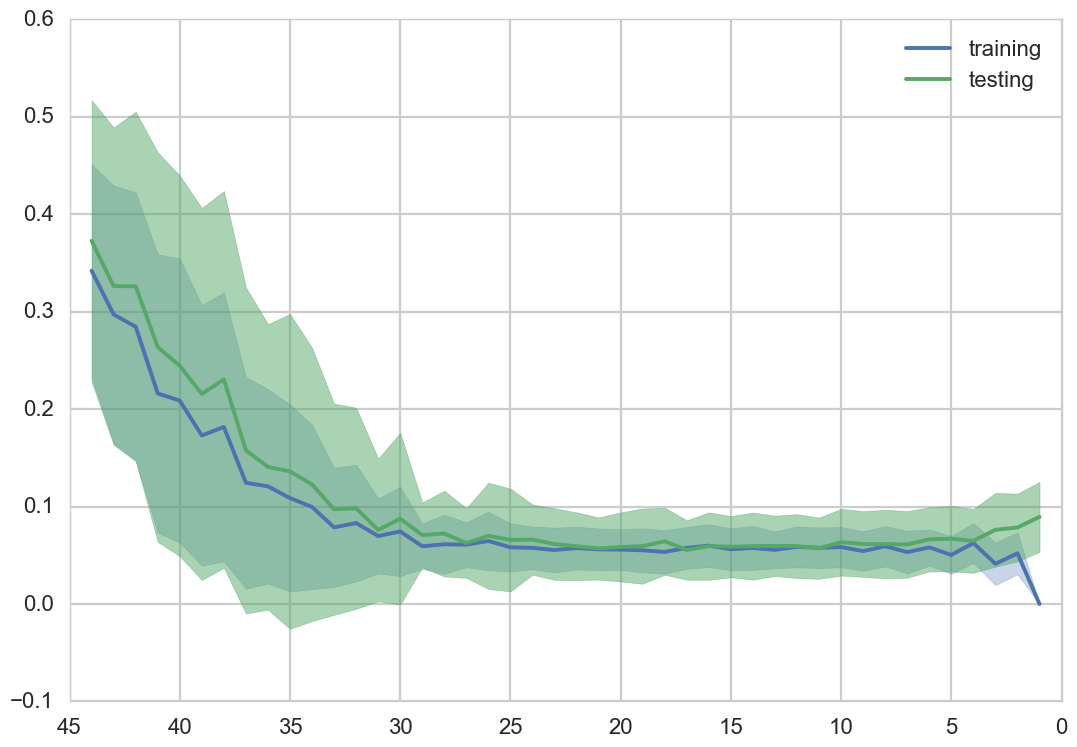

In [37]:
plt.gca().invert_xaxis()
plt.plot(nbrs, fmeanstr, color=c0, label="training");
plt.fill_between(nbrs, fmeanstr - fstdsstr, fmeanstr+fstdsstr, color=c0, alpha=0.3)
plt.plot(nbrs, fmeanste, color=c1, label="testing");
plt.fill_between(nbrs, fmeanste - fstdsste, fmeanste+fstdsste, color=c1, alpha=0.5)

plt.legend();

We plot the test error and training errors against the number of neighbors $k$ . Here $k$ serves as a complexity parameter, with small $k$ being more "wiggly" in the classification of neighborhoods and large $k$ oversmoothing the classification. Notice that we plot $k$ reversed on the x-axis so as to go from lower complexity to higher complexity. As expected, the training error drops with complexity, but the test error starts going back up. There is a large range of $k$ from 25 to 5, in which the fit is as good as it gets!

### Setting up some code

Lets set some code up for classification using cross-validation so that we can easily run classification models in scikit-learn. We first set up a function `cv_optimize` which takes a classifier `clf`, a grid of hyperparameters (such as a complexity parameter or regularization parameter) implemented as a dictionary `parameters`, a training set (as a samples x features array) `Xtrain`, and a set of labels `ytrain`. The code takes the traning set, splits it into `n_folds` parts, sets up `n_folds` folds, and carries out a cross-validation by splitting the training set into a training and validation section for each foldfor us. It prints the best value of the parameters, and returns the best classifier to us.

In [27]:
from sklearn.grid_search import GridSearchCV
def cv_optimize(clf, parameters, Xtrain, ytrain, n_folds=5):
    gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds)
    gs.fit(Xtrain, ytrain)
    print "BEST PARAMS", gs.best_params_
    best = gs.best_estimator_
    return best

/home/manish/anaconda2/lib/python2.7/site-packages/sklearn/grid_search.py:43: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. This module will be removed in 0.20.
  DeprecationWarning)


We then use this best classifier to fit the entire training set. This is done inside the `do_classify` function which takes a dataframe `indf` as input. It takes the columns in the list `featurenames` as the features used to train the classifier. The column `targetname` sets the target. The classification is done by setting those samples for which `targetname` has value `target1val` to the value 1, and all others to 0. We split the dataframe into 80% training and 20% testing by default, standardizing the dataset if desired.We then train the model on the training set using cross-validation. Having obtained the best classifier using `cv_optimize`, we retrain on the entire training set and calculate the training and testing accuracy, which we print. We return the split data and the trained classifier.

In [25]:
from sklearn.cross_validation import train_test_split
def do_classify(clf, parameters, indf, featurenames, targetname, target1val, standardize=False, train_size=0.8):
    subdf=indf[featurenames]
    if standardize:
        subdfstd=(subdf - subdf.mean())/subdf.std()
    else:
        subdfstd=subdf
    X=subdfstd.values
    y=(indf[targetname].values==target1val)*1
    Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, train_size=train_size)
    clf = cv_optimize(clf, parameters, Xtrain, ytrain)
    clf=clf.fit(Xtrain, ytrain)
    training_accuracy = clf.score(Xtrain, ytrain)
    test_accuracy = clf.score(Xtest, ytest)
    print "Accuracy on training data: %0.2f" % (training_accuracy)
    print "Accuracy on test data:     %0.2f" % (test_accuracy)
    return clf, Xtrain, ytrain, Xtest, ytest

#### Cross-Validation
Lets repeat what we have been doing so far and carry out a cross-validation. We're of-course now training on an even smaller set, so our results will be a bit different from the diagram above. We plot the results in the diagram below. The results are fairly stable and correspond to our intuition that the first principal component basically separates the data.

In [28]:
bestcv, Xtrain, ytrain, Xtest, ytest = do_classify(KNeighborsClassifier(), {"n_neighbors": range(1,40,2)}, df, ['pc1','pc2'], 'label', 'check' )

BEST PARAMS {'n_neighbors': 5}
Accuracy on training data: 0.94
Accuracy on test data:     0.94


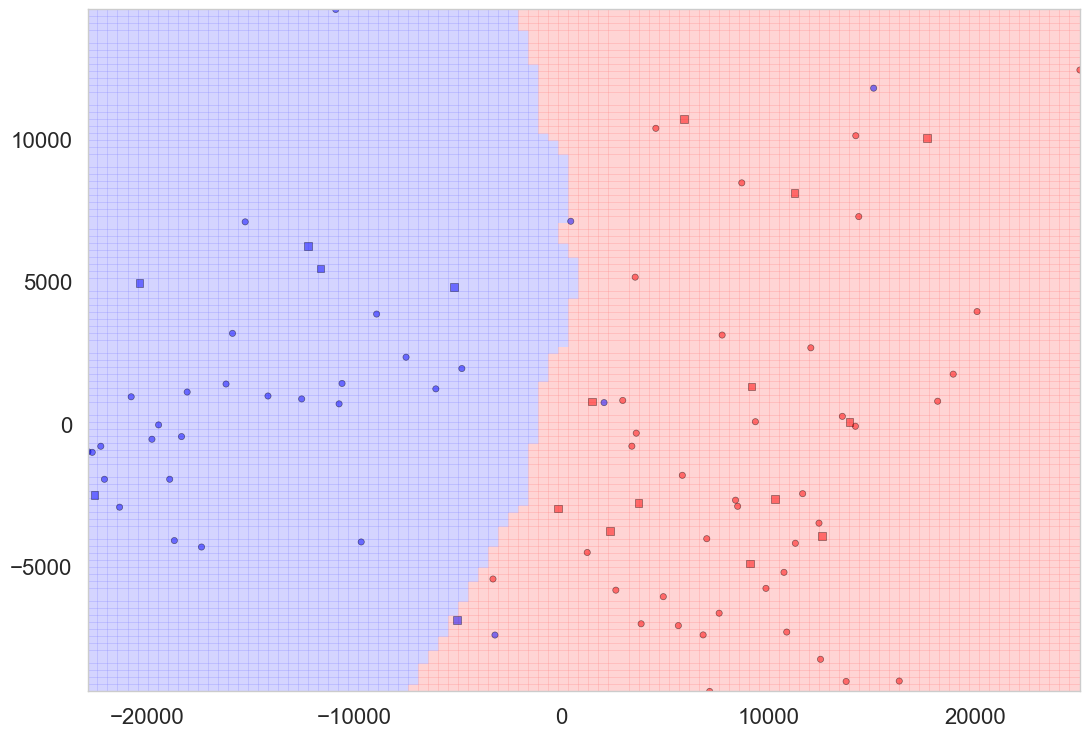

In [29]:
plt.figure()
ax=plt.gca()
points_plot(ax, Xtrain, Xtest, ytrain, ytest, bestcv, alpha=0.5, psize=20);

We can plot the probability contours as well.

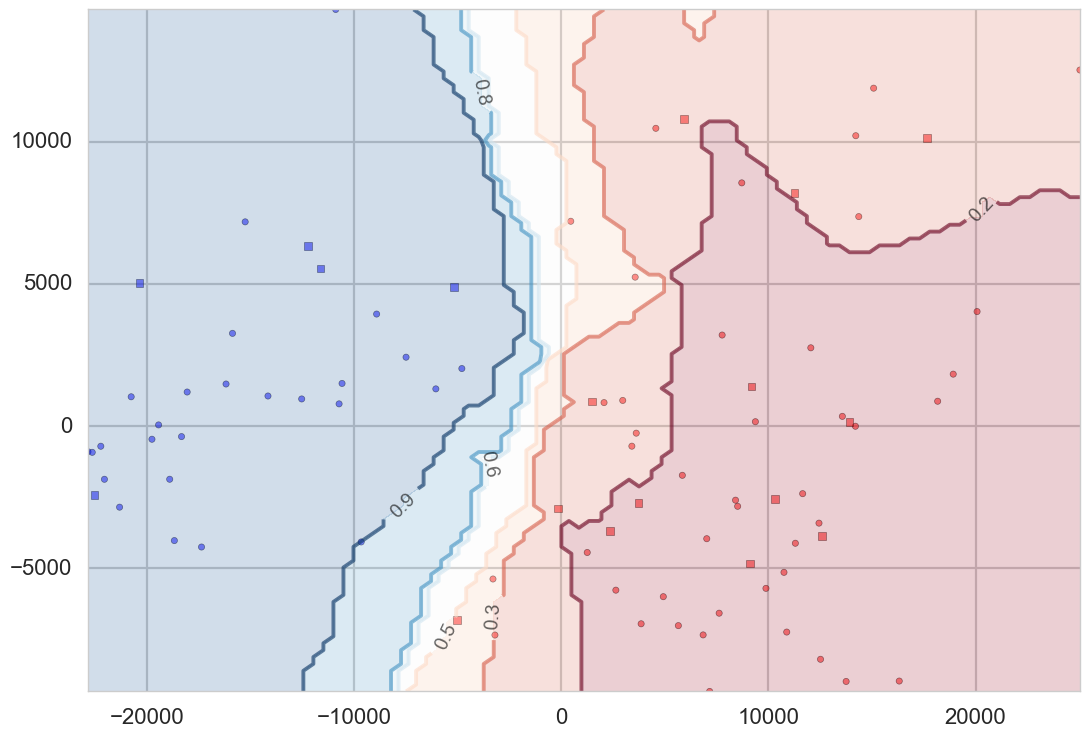

In [30]:
plt.figure()
ax=plt.gca()
points_plot_prob(ax, Xtrain, Xtest, ytrain, ytest, bestcv, alpha=0.5, psize=20);

## Evaluation

For the evaluation of this classifier we will use confusion matrix to check the values of false negatives and false positives predicted by this classifier.

In [32]:
from sklearn.metrics import confusion_matrix, classification_report
confusion_matrix(ytest, bestcv.predict(Xtest), )

array([[12,  0],
       [ 1,  5]])